In [ ]:
#| default_exp datasets

In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
#| export
from __future__ import annotations
import math, numpy as np, matplotlib.pyplot as plt
from operator import itemgetter
from itertools import zip_longest
import fastcore.all as fc

from torch.utils.data import default_collate

from miniai.training import *

In [ ]:
import logging,pickle,gzip,os,time,shutil,torch,matplotlib as mpl
from pathlib import Path

from torch import tensor,nn,optim
from torch.utils.data import DataLoader
import torch.nn.functional as F
from datasets import load_dataset,load_dataset_builder

import torchvision.transforms.functional as TF
from fastcore.test import test_close

In [ ]:
torch.set_printoptions(precision=2, linewidth=140, sci_mode=False)
torch.manual_seed(1)
mpl.rcParams['image.cmap'] = 'gray'

In [ ]:
logging.disable(logging.WARNING)

# Hugging Face Datasets 

Load a dataset builder from the Hugging Face Hub, or a local dataset. A dataset builder can be used to inspect general information that is required to build a dataset (cache directory, config, dataset info, etc.)
without downloading the dataset itself.

In [ ]:
name = 'fashion_mnist'
ds_builder = load_dataset_builder(name)
print(ds_builder.info.description)

Fashion-MNIST is a dataset of Zalando's article images—consisting of a training set of
60,000 examples and a test set of 10,000 examples. Each example is a 28x28 grayscale image,
associated with a label from 10 classes. We intend Fashion-MNIST to serve as a direct drop-in
replacement for the original MNIST dataset for benchmarking machine learning algorithms.
It shares the same image size and structure of training and testing splits.



We can get basic information from dataset builder like its features and splits

In [ ]:
ds_builder.info.features

{'image': Image(decode=True, id=None),
 'label': ClassLabel(num_classes=10, names=['T - shirt / top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot'], id=None)}

In [ ]:
ds_builder.info.splits

{'train': SplitInfo(name='train', num_bytes=31296655, num_examples=60000, dataset_name='fashion_mnist'),
 'test': SplitInfo(name='test', num_bytes=5233818, num_examples=10000, dataset_name='fashion_mnist')}

To load the dataset dictionary (dsd) itself we use `load_dataset`

In [ ]:
dsd = load_dataset(name)
dsd

Extracting data files:   0%|          | 0/4 [00:00<?, ?it/s]

Generating train split:   0%|          | 0/60000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/10000 [00:00<?, ? examples/s]

Dataset fashion_mnist downloaded and prepared to /root/.cache/huggingface/datasets/fashion_mnist/fashion_mnist/1.0.0/8d6c32399aa01613d96e2cbc9b13638f359ef62bb33612b077b4c247f6ef99c1. Subsequent calls will reuse this data.


  0%|          | 0/2 [00:00<?, ?it/s]

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 60000
    })
    test: Dataset({
        features: ['image', 'label'],
        num_rows: 10000
    })
})

In [ ]:
train, test = dsd['train'], dsd['test']
train[0]

{'image': <PIL.PngImagePlugin.PngImageFile image mode=L size=28x28>,
 'label': 9}

In [ ]:
x,y = ds_builder.info.features

In [ ]:
x,y

('image', 'label')

In [ ]:
img = train[x][0]
img

In [ ]:
xb = train[:5][x]
yb = train[:5][y]
yb

[9, 0, 0, 3, 0]

To convert integer class representation to actual labels we can grab labels from the `train.features` which will be of type `ClassLabel`. And use int2str method on it.

In [ ]:
featy = train.features[y]
featy

ClassLabel(num_classes=10, names=['T - shirt / top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot'], id=None)

In [ ]:
featy.int2str(yb)

['Ankle boot',
 'T - shirt / top',
 'T - shirt / top',
 'Dress',
 'T - shirt / top']

Instead of grabbing a subset of training data and then indexing into 'image' / 'label' we can index firstly

In [ ]:
train[:5][y]

[9, 0, 0, 3, 0]

In [ ]:
train[y][:5]

[9, 0, 0, 3, 0]

In [ ]:
train[x][0]

In DL we prefer to work with tensors rather than images. To convert a picture to a tensor we can use torch vision method `TF.to_tensor'

In [ ]:
TF.to_tensor?

Signature: TF.to_tensor(pic) -> torch.Tensor
Docstring:
Convert a ``PIL Image`` or ``numpy.ndarray`` to tensor.
This function does not support torchscript.

See :class:`~torchvision.transforms.ToTensor` for more details.

Args:
    pic (PIL Image or numpy.ndarray): Image to be converted to tensor.

Returns:
    Tensor: Converted image.
File:      /usr/local/lib/python3.9/dist-packages/torchvision/transforms/functional.py
Type:      function


In [ ]:
exmpl = train[:3]
exmpl

{'image': [<PIL.PngImagePlugin.PngImageFile image mode=L size=28x28>,
  <PIL.PngImagePlugin.PngImageFile image mode=L size=28x28>,
  <PIL.PngImagePlugin.PngImageFile image mode=L size=28x28>],
 'label': [9, 0, 0]}

In [ ]:
train

Dataset({
    features: ['image', 'label'],
    num_rows: 60000
})

In [ ]:
from itertools import islice
list(islice(iter(train),3))

[{'image': <PIL.PngImagePlugin.PngImageFile image mode=L size=28x28>,
  'label': 9},
 {'image': <PIL.PngImagePlugin.PngImageFile image mode=L size=28x28>,
  'label': 0},
 {'image': <PIL.PngImagePlugin.PngImageFile image mode=L size=28x28>,
  'label': 0}]

In [ ]:
def collate_fn(b) -> dict:
    """
    b is a list of dicts with lists of x and y. Convert it to a dict with tensors of x and y
    
    Example:
    {'image': [<PIL.PngImagePlugin.PngImageFile image mode=L size=28x28>, ...],
     'label': [9,...]}
    """
    # import ipdb; ipdb.set_trace()
    return {x: torch.stack([TF.to_tensor(o[x]) for o in b]),
            y: tensor([o[y] for o in b])}

`Train` is a Dataset. list of dictionaries, each dictionary consists of `x` and `y`. A batch is a slice of a list and also contains list of dictionaries. Torch works with tuples , so we use a `collate_fn` to:
* convert PIL image to a tensor and 
* stack xs and ys in separate tensors

We can better understand what is going on with `collate_fn` and why do we need it by setting trace.


In [ ]:
collate_fn(list(islice(iter(train),3)))

{'image': tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]]],
 
 
         [[[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]]],
 
 
         [[[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]]]]),
 'label': tensor([9, 0, 0])}

In [ ]:
dl = DataLoader(train,collate_fn=collate_fn, batch_size=16)
b = next(iter(dl))

In [ ]:
b[x].shape, b[y].shape

(torch.Size([16, 1, 28, 28]), torch.Size([16]))

Instead of writing a `collate_fn` we can skip it altogether and just use transforms. Behind the curtain, DataLoader will call `transforms` on each item when it calls `__getitem__`.

In [ ]:
def transforms(b):
    # we can index into HuggingFace Dataset and get back a dict of all xs and ys.
    # check below
    # import ipdb; ipdb.set_trace()
    b[x] = [TF.to_tensor(o) for o in b[x]]
    # because HF `with_transforms` requires a return value
    return b

In [ ]:
tds = train.with_transform(transforms) # uses default collation
dl = DataLoader(tds, batch_size=16)
b = next(iter(dl))
b[x].shape, b[y].shape

(torch.Size([16, 1, 28, 28]), torch.Size([16]))

By setting trace inside transforms we see that it works on each example:
 {'image': [<PIL.PngImagePlugin.PngImageFile image mode=L size=28x28 at 0x7F6A7E8041F0>], 'label': [9]}

Returning `b` in `transforms` is a bit redundant so we can make it work inplace and create a separate function (wrapper) that will take a in-place function and make it return a value

In [ ]:
def _transforms(b): b[x] = [TF.to_tensor(o) for o in b[x]]

In [ ]:
#|export
def inplace(f):
    def _f(b):
        f(b)
        return b
    return _f

In [ ]:
transformi = inplace(_transforms)

In [ ]:
r = train.with_transform(transformi)[0] 
r[x].shape, r[y]

(torch.Size([1, 28, 28]), 9)

We can use a Python decorator to simplify further and avoid calling `_transforms`

In [ ]:
@inplace
def transformi(b): b[x] = [TF.to_tensor(o) for o in b[x]]

In [ ]:
tdsf = train.with_transform(transformi)
r = tdsf[0]
r[x].shape, r[y]

(torch.Size([1, 28, 28]), 9)

In Python an `itemgetter` is a function that returns a function.

In [ ]:
d = dict(a=1,b=2,c=3)
ig = itemgetter('a','c')
ig(d)

(1, 3)

itemgetter does so by calling __getitem__ with passed arguments on the object. For example:

In [ ]:
class D:
    def __getitem__(self, k): return 1 if k=='a' else 2 if k=='b' else 3

In [ ]:
d = D()
ig(d)

(1, 3)

itemgetter works not only with dictionaries but with anything that has `__getitem__` method

In [ ]:
batch = dict(a=[1], b=[2]), dict(a=[3], b=[4]) 
batch

({'a': [1], 'b': [2]}, {'a': [3], 'b': [4]})

In [ ]:
default_collate(batch)

{'a': [tensor([1, 3])], 'b': [tensor([2, 4])]}

We can now get it all together and create a function `collate_dict` that returns a function that turns a dict of tensors into a tuple of tensors:
* creates an itemgetter that will use features and labels from a dataset to separate xs and ys 
* creates an internal function that default_collates a dictionary and retturns xs and ys in a tuple
* returns that function to be called on an input batch


In [ ]:
list(tdsf.features)

['image', 'label']

In [ ]:
tdsf

Dataset({
    features: ['image', 'label'],
    num_rows: 60000
})

In [ ]:
#|export
def collate_dict(ds):
    # import ipdb; ipdb.set_trace()
    # create a function (getter) to grab xs and ys
    get = itemgetter(*ds.features)
    # inner function to run getter on a collated dictionary
    def _f(b): return get(default_collate(b))
    return _f

In [ ]:
# EXAMPLE
itemgetter(*tdsf.features)
collate_dict(tdsf)(list(islice(tdsf,4)))

(tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]]],
 
 
         [[[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]]],
 
 
         [[[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]]],
 
 
         [[[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0.,

In [ ]:
dlf = DataLoader(tdsf, batch_size=4, collate_fn=collate_dict(tdsf))
xb, yb = next(iter(dlf))
xb.shape, yb

(torch.Size([4, 1, 28, 28]), tensor([9, 0, 0, 3]))

## Plotting images

It is very important to be able to vizualize things.

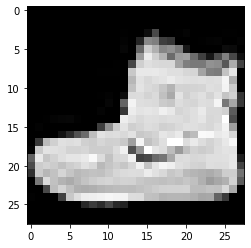

In [ ]:
b = next(iter(dl))
xb = b[x]
img = xb[0]
plt.imshow(img[0]);

We can start building plottinfg functions from the ground up. First of all let's create a function to show as single image. One of the arguments is `**kwargs` which can be passed to Axes.imshow. In order to get documentation for all possible keys we can use a decorator: `fc.delegates`

In [ ]:
#| export
@fc.delegates(plt.Axes.imshow)
def show_image(im, # image-like to show
               ax=None, # axes to show image on
               figsize=None, # size of a figure
               title=None, # titile of a figure
               noframe=True, # whether to show frame
               **kwargs):
    "Show a PIL or PyTorch image on ax"
    # check if image has tensor attributes
    # import ipdb; ipdb.set_trace()
    if im is None: return
    elif fc.hasattrs(im, ('cpu', 'permute', 'detach')):
        # detach and move to cpu
        im = im.detach().cpu()
        # if 3 dimensions and first dimension is less than 5: make channels last dimension:
        # (M, N, 3): an image with RGB values (0-1 float or 0-255 int).
        # (M, N, 4): an image with RGBA values (0-1 float or 0-255 int), i.e. including transparency.
        if len(im.shape) == 3 and im.shape[0]<5: im = im.permute(1,2,0)
    # if not tensor and not itself ndarray - cast as ndarray
    elif not isinstance(im, np.ndarray): im = np.array(im)
    # remove channels if it is 1 (greyscale image)
    if im.shape[-1] == 1: im = im.squeeze(-1)
    # create ax if it is None using subplots
    if ax is None: _, ax = plt.subplots(figsize=figsize)
    # show image
    ax.imshow(im, **kwargs)
    # set title
    if title is not None: ax.set_title(title)
    # remove xticks and yticks
    ax.set_xticks([])
    ax.set_yticks([])
    # remove axis if noframe
    if noframe: ax.axis('off')
    return ax

In [ ]:
help(show_image)

Help on function show_image in module __main__:

show_image(im, ax=None, figsize=None, title=None, noframe=True, *, cmap=None, norm=None, aspect=None, interpolation=None, alpha=None, vmin=None, vmax=None, origin=None, extent=None, interpolation_stage=None, filternorm=True, filterrad=4.0, resample=None, url=None, data=None)
    Show a PIL or PyTorch image on ax



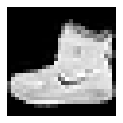

In [ ]:
show_image(img, figsize=(2,2));

Great, now we can plot a single image. Let's move on to plotting several images (subplots).

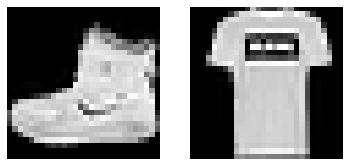

In [ ]:
fig, axs = plt.subplots(1,2)
show_image(img, axs[0])
show_image(xb[1], axs[1]);

In [ ]:
#|export
@fc.delegates(plt.subplots, keep=True)
def subplots(
    nrows:int = 1, # Number of rows in returned axes grid
    ncols:int = 1, # Number of columns in returned axes grid
    figsize:tuple = None, # (width, height) in inches of the returned figure
    imsize:int = 3, # Size (in inches) of images that will be displayed
    suptitle:str = None, # Title to be set to returned figure
    **kwargs,
): # fig and axes
    " A figure and set of subplots to display images of `imsize` inches."
    # if figsize is not given, estimate it as ncols x imsize and nrows x imsize
    if figsize is None: figsize = (ncols * imsize), (nrows * imsize)
    # return figure and ax
    fig, ax = plt.subplots(nrows, ncols, figsize=figsize)
    # add suptitles
    if suptitle is not None: fig.suptitle(suptitle)
    # if we have a single image, create an array of it
    if nrows*ncols==1: ax = np.array([ax])
    return fig, ax

In [ ]:
from nbdev.showdoc import *

In [ ]:
show_doc(subplots)

---

[source](https://github.com/Iamalos/fastai-p2/blob/main/miniai/datasets.py#L71){target="_blank" style="float:right; font-size:smaller"}

### subplots

>      subplots (nrows:int=1, ncols:int=1, figsize:tuple=None, imsize:int=3,
>                suptitle:str=None, sharex=False, sharey=False, squeeze=True,
>                subplot_kw=None, gridspec_kw=None, **kwargs)

A figure and set of subplots to display images of `imsize` inches.

|    | **Type** | **Default** | **Details** |
| -- | -------- | ----------- | ----------- |
| nrows | int | 1 | Number of rows in returned axes grid |
| ncols | int | 1 | Number of columns in returned axes grid |
| figsize | tuple | None | (width, height) in inches of the returned figure |
| imsize | int | 3 | Size (in inches) of images that will be displayed |
| suptitle | str | None | Title to be set to returned figure |
| sharex | bool | False |  |
| sharey | bool | False |  |
| squeeze | bool | True |  |
| subplot_kw | NoneType | None |  |
| gridspec_kw | NoneType | None |  |
| kwargs |  |  |  |

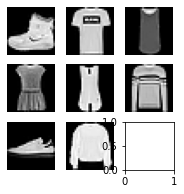

In [ ]:
fig,axs = subplots(3,3,imsize=1)
imgs=xb[:8]
for ax, img in zip(axs.flat, imgs): show_image(img,ax)

Now we write a method to automatically find a suitable grid to show images.

In [ ]:
#| export
@fc.delegates(subplots)
def get_grid(
    n:int, # Number of axes
    nrows:int = None, # Number of rows, defaulting to `int(math.sqrt(n))`
    ncols:int = None, # Number of cols, defaulting to `ceil(n/rows)`
    title:str = None, # If passed, title set to the figure
    weight:str = 'bold', # Title font weight
    size:int = 14, # Title font size
    **kwargs,
): # fig and axs
    "Return a grid of `n` axes, `rows` by `cols`"
    # if nrows is provided find the necessary ncols
    if nrows: ncols = ncols or int(np.ceil(n/nrows))  
    # vice-versa to rows
    elif ncols: nrows = nrows or int(np.ceil(n/nrows)) # originally it was floor
    # if no rows and no cols, estimate rows and cols to make a square figure
    else:
        nrows = int(np.sqrt(n))
        ncols = int(np.ceil(n/nrows)) # originally it was floor
     # get figure and axes using our `subplots` method
    fig, axs = subplots(nrows, ncols, **kwargs)
    # remove axis for empty grid cells
    for i in range(n, nrows*ncols): axs.flat[i].set_axis_off()
    # add titles
    if title is not None: fig.suptitle(title, weight=weight, size=size)
    return fig, axs

(<Figure size 288x144 with 8 Axes>,
 array([[<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>],
        [<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>]],
       dtype=object))

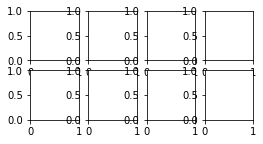

In [ ]:
get_grid(len(imgs),imsize=1)

In [ ]:
 int(np.sqrt(len(imgs)))

2

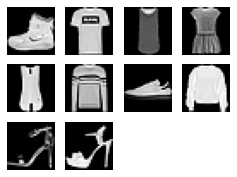

In [ ]:
fig,axs = get_grid(10,imsize=1)
imgs=xb[:10]
for ax, img in zip(axs.flat, imgs): show_image(img,ax)

Now we can pull it all together in one function that will estimate the number of rows and columns in a grid and plot images.

Note:
`flat` creates a `numpy.flatiter`
It creates an iterator that iterates over the elements of an array in a flattened, one-dimensional traversal, regardless of its original shape.
It's useful for accessing and processing all elements sequentially without explicitly creating a flattened copy of the array, saving memory and time.

In [ ]:
#|export
@fc.delegates(subplots)
def show_images(ims: list, # Images to show
                nrows: int|None=None, # Number of rows in a grid
                ncols: int|None=None, # Number of columns in grid(auto-calculated if None)
                titles:list|None=None, # Optional list of titles for each image
                **kwargs
               ):
    axs = get_grid(len(ims), nrows, ncols, **kwargs)[1].flat
    # import ipdb; ipdb.set_trace()
    for im, t, ax in zip_longest(ims, titles or [], axs): show_image(im, ax=ax, title=t)

In [ ]:
yb = b[y]
lbls = yb[:10]

In [ ]:
names = "Top Trouser Pullover Dress Coat Sandal Shirt Sneaker Bag Boot".split()
titles = itemgetter(*lbls)(names)
' '.join(titles)

'Boot Top Top Dress Top Pullover Sneaker Pullover Sandal Sandal'

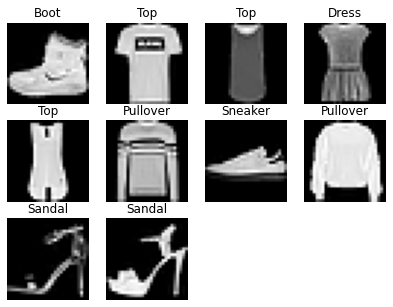

In [ ]:
# %debug
show_images(imgs, imsize=1.7, titles=titles)

Add desciption below **TODO**

In [ ]:
#|export
class DataLoaders: 
    def __init__(self, *dls): self.train, self.valid = dls[:2]
    
    @classmethod
    def from_dd(cls, dd, batch_size, as_tuple=True, **kwargs):
        f = collate_dict(dd['train'])
        return cls(*get_dls(*dd.values(), bs=batch_size, collate_fn=f, **kwargs))

## Export - 

In [ ]:
import nbdev; nbdev.nbdev_export()